# Library

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Dataset

In [ ]:
# Load dataset
!wget https://raw.githubusercontent.com/GoEco-Living/MachineLearning/refs/heads/main/Dataset/transport.csv

PATH = '/content/'
transport_df = pd.read_csv(PATH + 'transport.csv')

--2024-12-02 10:09:06--  https://raw.githubusercontent.com/GoEco-Living/MachineLearning/refs/heads/main/Dataset/transport.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15386 (15K) [text/plain]
Saving to: ‘transport.csv.2’

transport.csv.2     100%[===================>]  15.03K  --.-KB/s    in 0s      

2024-12-02 10:09:06 (71.8 MB/s) - ‘transport.csv.2’ saved [15386/15386]



## Transport Model

In [ ]:
transport_df.sample(5)

,Category,Carbon Emission (kg CO2),Distance (km)
43,Public,3.11,87.53
782,Public,31.83,215.26
264,Private,42.75,250.29
618,Public,5.77,211.15
639,Public,2.38,83.02


In [ ]:
transport_df["Category_encoded"] = LabelEncoder().fit_transform(transport_df["Category"])

# Normalize Distance
distance_scaler = MinMaxScaler()
transport_df["Distance_normalized"] = distance_scaler.fit_transform(transport_df[["Distance (km)"]])

# Target Variable
emission_scaler = MinMaxScaler()
transport_df["Carbon_Emission_normalized"] = emission_scaler.fit_transform(transport_df[["Carbon Emission (kg CO2)"]])

# Prepare Features and Target
X_category = transport_df["Category_encoded"].values
X_distance = transport_df["Distance_normalized"].values
y = transport_df["Carbon_Emission_normalized"].values

# Train-test Split
X_cat_train, X_cat_test, X_dist_train, X_dist_test, y_train, y_test = train_test_split(
    X_category, X_distance, y, test_size=0.2, random_state=42
)

# Create Model
def create_transport_model(num_categories):
    # Category Input
    category_input = tf.keras.layers.Input(shape=(1,), name="category_input")
    category_embedding = tf.keras.layers.Embedding(input_dim=num_categories, output_dim=5)(category_input)
    category_flatten = tf.keras.layers.Flatten()(category_embedding)

    # Distance Input
    distance_input = tf.keras.layers.Input(shape=(1,), name="distance_input")

    # Combine Inputs
    combined = tf.keras.layers.Concatenate()([category_flatten, distance_input])

    # Dense Layers
    dense_1 = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)
    dense_2 = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_1)
    carbon_output = tf.keras.layers.Dense(1, activation="linear", name="carbon_output")(dense_2)

    # Model
    model = tf.keras.Model(inputs=[category_input, distance_input], outputs=[carbon_output])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Number of unique categories
num_categories = transport_df["Category_encoded"].nunique()

# Create and Compile Model
transport_model = create_transport_model(num_categories)


In [ ]:
history = transport_model.fit(
    [X_cat_train, X_dist_train],
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.5857 - mae: 0.1843 - val_loss: 0.4735 - val_mae: 0.1198
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.4657 - mae: 0.1405 - val_loss: 0.3948 - val_mae: 0.1314
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3874 - mae: 0.1464 - val_loss: 0.3281 - val_mae: 0.1274
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.3212 - mae: 0.1377 - val_loss: 0.2726 - val_mae: 0.1213
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2746 - mae: 0.1471 - val_loss: 0.2271 - val_mae: 0.1219
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2253 - mae: 0.1359 - val_loss: 0.1893 - val_mae: 0.1189
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1916 - mae: 0.1462 - val_loss: 0.1587 - val_mae: 0.1219
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1610 - mae: 0.1372 - val_loss: 0.1334 - val_mae: 0.1209
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

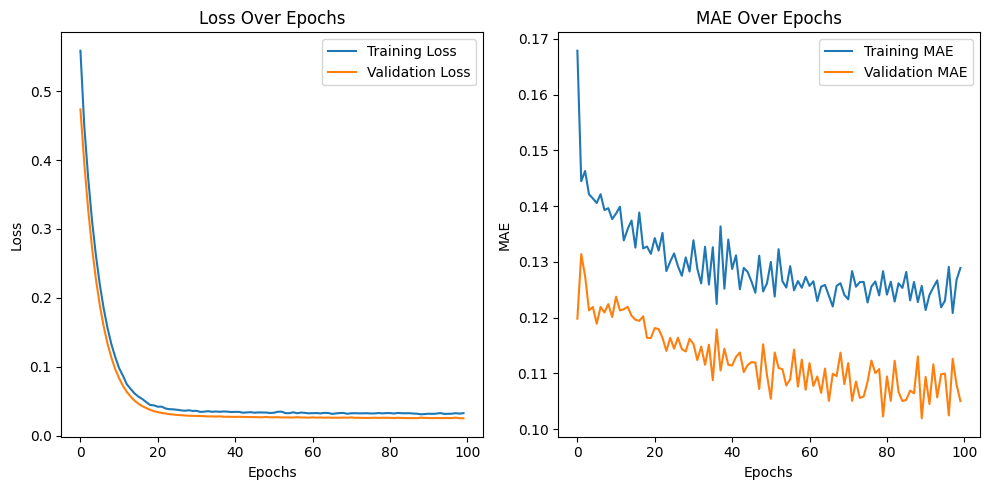

In [ ]:
def plot_training_history(history):
    # Plot Loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history["mae"], label="Training MAE")
    plt.plot(history.history["val_mae"], label="Validation MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MAE")
    plt.title("MAE Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history)